# Multi-Layer Perceptron Model for User Activity Prediction

**Goal**: Predict whether users will be active or inactive based on early actions

**Baseline to beat (Random Forest)**:
- Accuracy: 0.8496
- ROC-AUC: 0.8994
- F1-Score: 0.8500

## 1. Imports and Setup

In [4]:
import logging
import time
from typing import Tuple, Dict, Any
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers
from tensorflow.keras.models import Sequential

import keras_tuner as kt

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# Set seeds
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
Keras version: 3.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Load and Explore Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading data...
Dataset shape: (20011, 31)

First few rows:


,userId,y_active,province,age_gender_missing,followCnt_log,usr_actions_taken,usr_like_rate,usr_share_rate,usr_comment_rate,usr_ever_inthomeviewed,...,usr_only_click,usr_shared_x_liked,usr_shared_x_commented,usr_intohome_x_liked,avg_pop_index_pca,avg_content_pop_index,avg_pop_rank_exposure_row,avg_publishTime,max_creator_pop_index,entropy_pca
0,ICKCJCGCLCNCGCGCKC,0,hu nan,1,1.386294,1,0.0,0.0,0.0,0,...,1,0,0,0,2.256349,0.480283,1.180606,48.0,2.267197,-1.386364
1,ICKCMCHCJCKCJCGCJC,0,zhe jiang,1,1.791759,2,0.0,0.0,0.0,0,...,1,0,0,0,2.165024,1.093763,8.046980,99.5,5.094862,0.651362
2,ICMCICMCNCPCHCHCMC,0,jiang su,1,1.386294,2,0.0,0.0,0.0,0,...,1,0,0,0,3.397363,2.701603,1.068558,96.5,3.110705,0.651362
3,ICMCKCICKCPCLCKCOC,0,hu bei,1,1.609438,1,0.0,0.0,0.0,0,...,1,0,0,0,2.986047,0.246188,0.690819,26.0,1.754418,-1.386364
4,ICNCICLCICPCLCICOC,0,hu bei,1,1.386294,1,0.0,0.0,0.0,0,...,1,0,0,0,-2.020211,0.186660,0.155593,164.0,-0.820507,-1.386364



Target variable distribution:
y_active
0    14230
1     5781
Name: count, dtype: int64

Class balance:
y_active
0    0.711109
1    0.288891
Name: proportion, dtype: float64


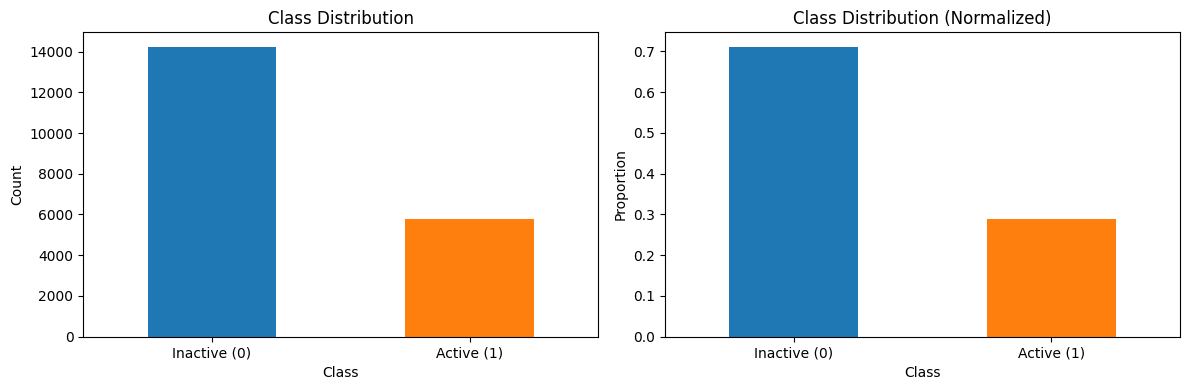

In [6]:
# Load data
print("Loading data...")
df = pd.read_csv("/content/drive/MyDrive/user_level_data-2.csv")
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

# Target distribution
print("\nTarget variable distribution:")
print(df["y_active"].value_counts())
print("\nClass balance:")
print(df["y_active"].value_counts(normalize=True))

# Visualize class distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
df["y_active"].value_counts().plot(kind="bar", ax=ax[0], color=["#1f77b4", "#ff7f0e"])
ax[0].set_title("Class Distribution")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Count")
ax[0].set_xticklabels(["Inactive (0)", "Active (1)"], rotation=0)

df["y_active"].value_counts(normalize=True).plot(kind="bar", ax=ax[1], color=["#1f77b4", "#ff7f0e"])
ax[1].set_title("Class Distribution (Normalized)")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Proportion")
ax[1].set_xticklabels(["Inactive (0)", "Active (1)"], rotation=0)
plt.tight_layout()
plt.show()

## 3. Prepare Features and Target

In [7]:
# Drop ID columns
id_cols = [col for col in df.columns if "id" in col.lower() or col == "userId"]
print(f"Dropping ID columns: {id_cols}")

X = df.drop(columns=id_cols + ["y_active"])
y = df["y_active"]

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()}")

Dropping ID columns: ['userId']

Feature matrix shape: (20011, 29)
Target vector shape: (20011,)

Feature columns: ['province', 'age_gender_missing', 'followCnt_log', 'usr_actions_taken', 'usr_like_rate', 'usr_share_rate', 'usr_comment_rate', 'usr_ever_inthomeviewed', 'usr_ever_shared', 'usr_ever_commented', 'usr_shares_per_exp_follow', 'usr_sum_isLike_x_followlog', 'usr_sum_isComment_x_followlog', 'usr_followlog_x_actionrate', 'usr_engagement_span', 'usr_avg_dwell', 'usr_avg_position', 'usr_active_days', 'usr_weekend_share', 'usr_only_click', 'usr_shared_x_liked', 'usr_shared_x_commented', 'usr_intohome_x_liked', 'avg_pop_index_pca', 'avg_content_pop_index', 'avg_pop_rank_exposure_row', 'avg_publishTime', 'max_creator_pop_index', 'entropy_pca']


## 4. Train-Val-Test Split

In [8]:
# Split data (80/20 train/test, then 85/15 train/val)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=RANDOM_STATE, stratify=y_train
)

print(f"Training set size:   {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size:       {X_test.shape}")

Training set size:   (13606, 29)
Validation set size: (2402, 29)
Test set size:       (4003, 29)


## 5. Feature Preprocessing

In [9]:
# Identify numeric and categorical columns
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

print(f"Numeric features: {len(num_cols)}")
print(f"Categorical features: {len(cat_cols)}")
if cat_cols:
    print(f"Categorical columns: {cat_cols}")

# Scale numeric features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_cols])
X_val_num = scaler.transform(X_val[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

# Encode categorical features
if cat_cols:
    encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_train_cat = encoder.fit_transform(X_train[cat_cols])
    X_val_cat = encoder.transform(X_val[cat_cols])
    X_test_cat = encoder.transform(X_test[cat_cols])

    # Concatenate
    X_train_processed = np.hstack([X_train_num, X_train_cat])
    X_val_processed = np.hstack([X_val_num, X_val_cat])
    X_test_processed = np.hstack([X_test_num, X_test_cat])
else:
    X_train_processed = X_train_num
    X_val_processed = X_val_num
    X_test_processed = X_test_num

print(f"\nProcessed training data shape: {X_train_processed.shape}")
print(f"Processed validation data shape: {X_val_processed.shape}")
print(f"Processed test data shape: {X_test_processed.shape}")

Numeric features: 28
Categorical features: 1
Categorical columns: ['province']

Processed training data shape: (13606, 29)
Processed validation data shape: (2402, 29)
Processed test data shape: (4003, 29)


## 6. Compute Class Weights

In [10]:
# Compute class weights for imbalanced data
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}
print(f"Class weights: {class_weights}")

Class weights: {0: np.float64(0.7031524547803617), 1: np.float64(1.7306029000254388)}


## 7. Define Model Building Function

In [11]:
def build_model(hp: kt.HyperParameters, input_dim: int) -> keras.Model:
    """
    Build MLP model with hyperparameter tuning.

    Args:
        hp: Keras Tuner HyperParameters object
        input_dim: Number of input features

    Returns:
        Compiled Keras model
    """
    model = Sequential(name="MLP_UserActivity")

    # Input layer
    model.add(layers.Input(shape=(input_dim,)))

    # Number of hidden layers
    n_layers = hp.Int("n_layers", min_value=2, max_value=5, default=3)

    for i in range(n_layers):
        # Neurons per layer (decreasing pattern)
        if i == 0:
            units = hp.Int(f"units_layer_{i}", min_value=128, max_value=512, step=64, default=256)
        else:
            # Each layer has fewer neurons than the previous
            prev_units = hp.get(f"units_layer_{i-1}")
            max_units = max(64, prev_units // 2)
            units = hp.Int(f"units_layer_{i}", min_value=64, max_value=max_units, step=32, default=max_units)

        # Dense layer with L2 regularization
        l2_rate = hp.Float(f"l2_layer_{i}", min_value=1e-5, max_value=1e-2, sampling="log", default=1e-4)
        model.add(layers.Dense(
            units=units,
            kernel_regularizer=regularizers.l2(l2_rate),
            name=f"dense_{i}"
        ))

        # Batch normalization
        if hp.Boolean(f"batch_norm_{i}", default=True):
            model.add(layers.BatchNormalization(name=f"batch_norm_{i}"))

        # Activation
        activation = hp.Choice(f"activation_{i}", values=["relu", "elu", "selu"], default="relu")
        model.add(layers.Activation(activation, name=f"activation_{i}"))

        # Dropout
        dropout_rate = hp.Float(f"dropout_{i}", min_value=0.1, max_value=0.5, step=0.1, default=0.3)
        model.add(layers.Dropout(dropout_rate, name=f"dropout_{i}"))

    # Output layer
    model.add(layers.Dense(1, activation="sigmoid", name="output"))

    # Optimizer
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log", default=1e-3)
    optimizer_name = hp.Choice("optimizer", values=["adam", "adamw", "rmsprop"], default="adam")

    if optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "adamw":
        optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    # Compile
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auc"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall")
        ]
    )

    return model

## 8. Hyperparameter Tuning with Hyperband

In [12]:
print("Starting Hyperparameter Tuning...\n")

# Use RandomSearch instead of Hyperband - more predictable and fewer trials
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, X_train_processed.shape[1]),
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=20,  # Explicit limit - will do exactly 20 trials
    executions_per_trial=1,
    directory="mlp_tuning",
    project_name="user_activity_prediction",
    overwrite=True,
    seed=RANDOM_STATE
)

# Callbacks for tuning
early_stop_tuning = callbacks.EarlyStopping(
    monitor="val_auc",
    patience=10,
    mode="max",
    restore_best_weights=True,
    verbose=0
)

# Search with memory optimization
tuner.search(
    X_train_processed, y_train.values,
    epochs=50,  # Reduced from 100
    batch_size=64,  # Reduced from 128 for less memory
    validation_data=(X_val_processed, y_val.values),
    class_weight=class_weights,
    callbacks=[early_stop_tuning],
    verbose=1
)

print("\nHyperparameter tuning completed!")

Trial 20 Complete [00h 00m 43s]
val_auc: 0.9372933506965637

Best val_auc So Far: 0.9401737451553345
Total elapsed time: 00h 13m 24s

Hyperparameter tuning completed!


## 9. Best Hyperparameters

In [13]:
# Get best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

print("="*60)
print("BEST HYPERPARAMETERS")
print("="*60)
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

# Display tuning results summary
print("\n" + "="*60)
print("TOP 5 MODELS")
print("="*60)
tuner.results_summary(num_trials=5)

BEST HYPERPARAMETERS
n_layers: 3
units_layer_0: 448
l2_layer_0: 3.9697770718765924e-05
batch_norm_0: True
activation_0: relu
dropout_0: 0.2
units_layer_1: 64
l2_layer_1: 4.0833005035583936e-05
batch_norm_1: False
activation_1: elu
dropout_1: 0.5
units_layer_2: 64
l2_layer_2: 0.001907587355025412
batch_norm_2: False
activation_2: relu
dropout_2: 0.2
learning_rate: 0.0006426228293037218
optimizer: adam
units_layer_3: 64
l2_layer_3: 2.7830026454369402e-05
batch_norm_3: True
activation_3: selu
dropout_3: 0.5

TOP 5 MODELS
Results summary
Results in mlp_tuning/user_activity_prediction
Showing 5 best trials
Objective(name="val_auc", direction="max")

Trial 02 summary
Hyperparameters:
n_layers: 3
units_layer_0: 448
l2_layer_0: 3.9697770718765924e-05
batch_norm_0: True
activation_0: relu
dropout_0: 0.2
units_layer_1: 64
l2_layer_1: 4.0833005035583936e-05
batch_norm_1: False
activation_1: elu
dropout_1: 0.5
units_layer_2: 64
l2_layer_2: 0.001907587355025412
batch_norm_2: False
activation_2: rel

## 10. Build and Train Final Model

In [14]:
# Build model with best hyperparameters
final_model = build_model(best_hp, X_train_processed.shape[1])

print("="*60)
print("FINAL MODEL ARCHITECTURE")
print("="*60)
final_model.summary()

# Combine train and validation sets for final training
X_train_full = np.vstack([X_train_processed, X_val_processed])
y_train_full = np.concatenate([y_train.values, y_val.values])

print(f"\nFull training set shape: {X_train_full.shape}")
print(f"Test set shape: {X_test_processed.shape}")

FINAL MODEL ARCHITECTURE


Model: "MLP_UserActivity"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 448)            │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_0                    │ (None, 448)            │         1,792 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_0 (Activation)       │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        28,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,193 (188.25 KB)

 Trainable params: 47,297 (184.75 KB)

 Non-trainable params: 896 (3.50 KB)


Full training set shape: (16008, 29)
Test set shape: (4003, 29)


In [15]:
# Training callbacks
early_stop = callbacks.EarlyStopping(
    monitor="val_auc",
    patience=20,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_auc",
    factor=0.5,
    patience=10,
    mode="max",
    min_lr=1e-6,
    verbose=1
)

# Train
print("\nTraining final model...\n")
history = final_model.fit(
    X_train_full, y_train_full,
    epochs=200,
    batch_size=64,
    validation_data=(X_test_processed, y_test.values),
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\nTraining completed!")


Training final model...

Epoch 1/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7407 - auc: 0.8249 - loss: 0.6124 - precision: 0.5376 - recall: 0.7886 - val_accuracy: 0.8519 - val_auc: 0.9271 - val_loss: 0.3957 - val_precision: 0.6693 - val_recall: 0.9628 - learning_rate: 6.4262e-04
Epoch 2/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8386 - auc: 0.9137 - loss: 0.4150 - precision: 0.6508 - recall: 0.9547 - val_accuracy: 0.8494 - val_auc: 0.9306 - val_loss: 0.3694 - val_precision: 0.6608 - val_recall: 0.9827 - learning_rate: 6.4262e-04
Epoch 3/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8416 - auc: 0.9196 - loss: 0.3735 - precision: 0.6533 - recall: 0.9643 - val_accuracy: 0.8499 - val_auc: 0.9320 - val_loss: 0.3452 - val_precision: 0.6611 - val_recall: 0.9853 - learning_rate: 6.4262e-04
Epoch 4/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8459 - auc: 0.9194 - loss: 0.3531 - precision: 0.6578 - recall: 0.9744 - val_accuracy: 0.850

## 11. Model Evaluation

In [16]:
# Predictions
y_pred_proba = final_model.predict(X_test_processed, verbose=0).flatten()
y_pred = (y_pred_proba >= 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)

# Print results
print("\n" + "="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nConfusion Matrix:")
print(cm)
print(f"\nROC-AUC Score: {roc_auc:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

print("\n" + "="*60)
print("COMPARISON WITH BASELINE (Random Forest)")
print("="*60)
print(f"Accuracy:   MLP: {accuracy:.4f} | RF: 0.8496 | Diff: {accuracy - 0.8496:+.4f}")
print(f"ROC-AUC:    MLP: {roc_auc:.4f} | RF: 0.8994 | Diff: {roc_auc - 0.8994:+.4f}")
print(f"F1-Score:   MLP: {f1:.4f} | RF: 0.8500 | Diff: {f1 - 0.8500:+.4f}")


MODEL PERFORMANCE METRICS

Accuracy: 0.8509

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      2847
           1       0.66      0.99      0.79      1156

    accuracy                           0.85      4003
   macro avg       0.83      0.89      0.84      4003
weighted avg       0.90      0.85      0.86      4003


Confusion Matrix:
[[2262  585]
 [  12 1144]]

ROC-AUC Score: 0.9373
F1 Score (weighted): 0.8573

COMPARISON WITH BASELINE (Random Forest)
Accuracy:   MLP: 0.8509 | RF: 0.8496 | Diff: +0.0013
ROC-AUC:    MLP: 0.9373 | RF: 0.8994 | Diff: +0.0379
F1-Score:   MLP: 0.8573 | RF: 0.8500 | Diff: +0.0073


## 12. Comprehensive Visualizations

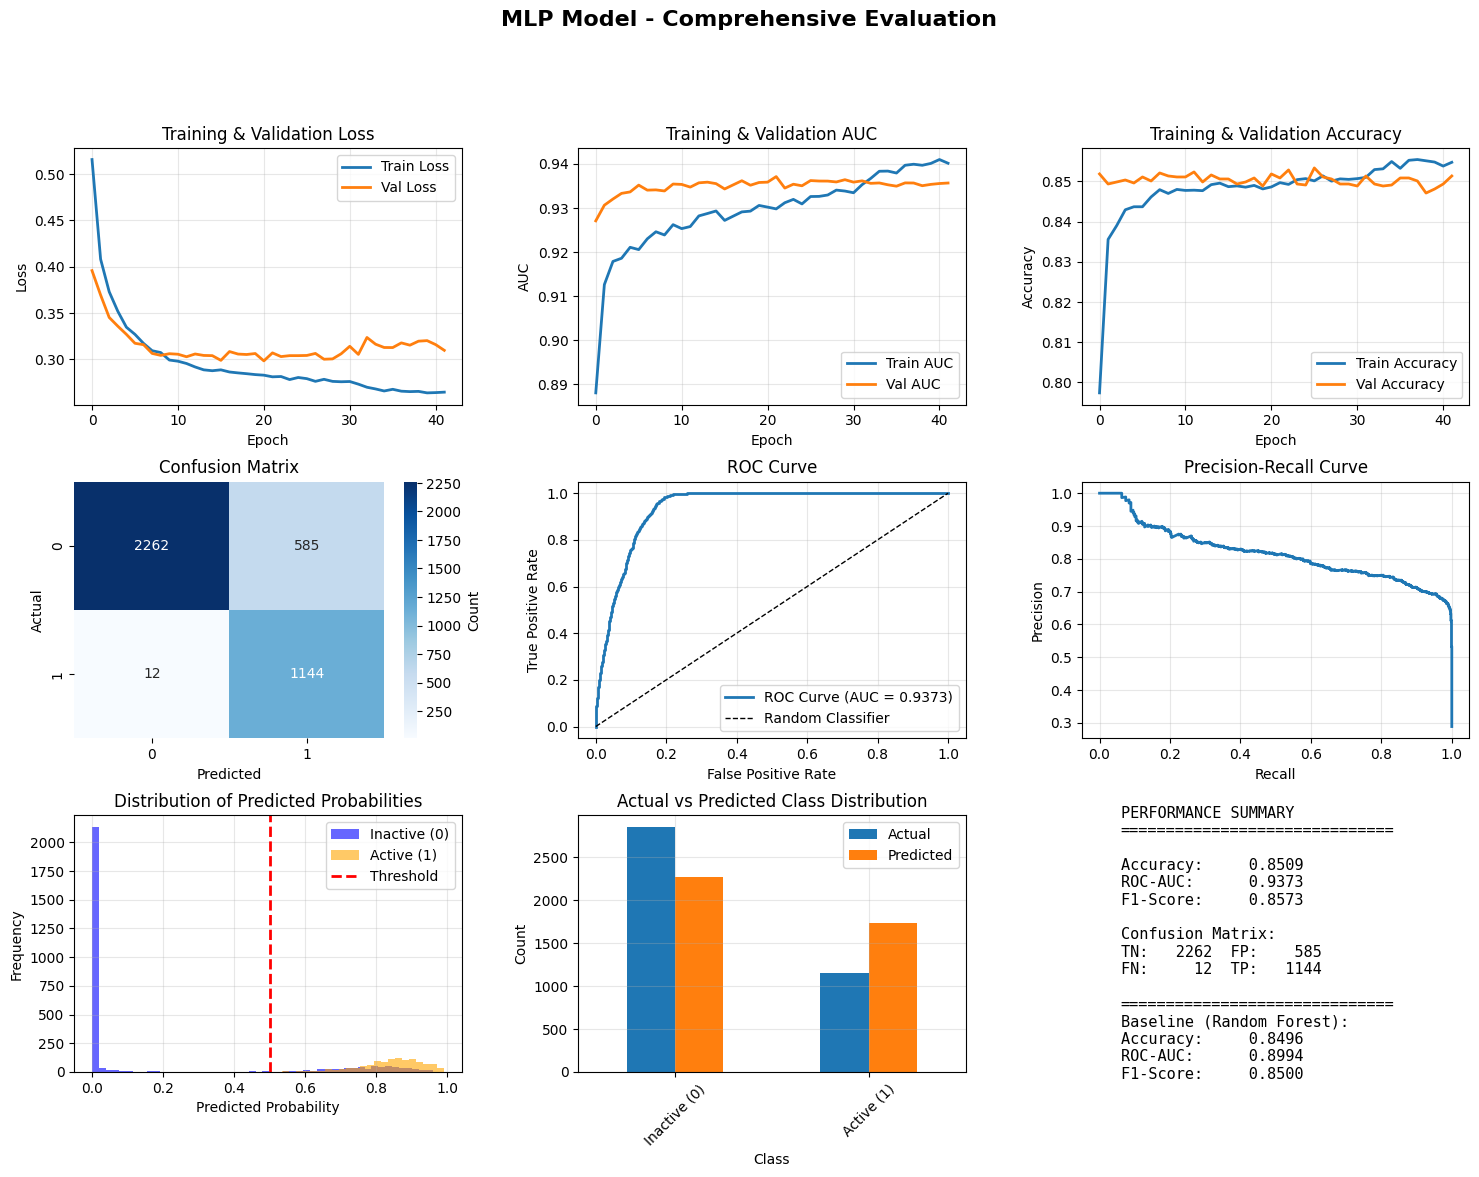

In [17]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Training History - Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(history.history["loss"], label="Train Loss", linewidth=2)
ax1.plot(history.history["val_loss"], label="Val Loss", linewidth=2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training & Validation Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Training History - AUC
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(history.history["auc"], label="Train AUC", linewidth=2)
ax2.plot(history.history["val_auc"], label="Val AUC", linewidth=2)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("AUC")
ax2.set_title("Training & Validation AUC")
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Training History - Accuracy
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(history.history["accuracy"], label="Train Accuracy", linewidth=2)
ax3.plot(history.history["val_accuracy"], label="Val Accuracy", linewidth=2)
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Accuracy")
ax3.set_title("Training & Validation Accuracy")
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Confusion Matrix
ax4 = fig.add_subplot(gs[1, 0])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax4, cbar_kws={"label": "Count"})
ax4.set_title("Confusion Matrix")
ax4.set_ylabel("Actual")
ax4.set_xlabel("Predicted")

# 5. ROC Curve
ax5 = fig.add_subplot(gs[1, 1])
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax5.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", linewidth=2)
ax5.plot([0, 1], [0, 1], "k--", label="Random Classifier", linewidth=1)
ax5.set_xlabel("False Positive Rate")
ax5.set_ylabel("True Positive Rate")
ax5.set_title("ROC Curve")
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Precision-Recall Curve
ax6 = fig.add_subplot(gs[1, 2])
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ax6.plot(recall, precision, linewidth=2)
ax6.set_xlabel("Recall")
ax6.set_ylabel("Precision")
ax6.set_title("Precision-Recall Curve")
ax6.grid(True, alpha=0.3)

# 7. Prediction Distribution
ax7 = fig.add_subplot(gs[2, 0])
ax7.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.6, label="Inactive (0)", color="blue")
ax7.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.6, label="Active (1)", color="orange")
ax7.axvline(x=0.5, color="red", linestyle="--", linewidth=2, label="Threshold")
ax7.set_xlabel("Predicted Probability")
ax7.set_ylabel("Frequency")
ax7.set_title("Distribution of Predicted Probabilities")
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Class Distribution Comparison
ax8 = fig.add_subplot(gs[2, 1])
class_comparison = pd.DataFrame({
    "Actual": y_test.value_counts().sort_index(),
    "Predicted": pd.Series(y_pred).value_counts().sort_index()
})
class_comparison.plot(kind="bar", ax=ax8, color=["#1f77b4", "#ff7f0e"])
ax8.set_xlabel("Class")
ax8.set_ylabel("Count")
ax8.set_title("Actual vs Predicted Class Distribution")
ax8.set_xticklabels(["Inactive (0)", "Active (1)"], rotation=45)
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Metrics Summary
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis("off")
metrics_text = f"""
PERFORMANCE SUMMARY
{'='*30}

Accuracy:     {accuracy:.4f}
ROC-AUC:      {roc_auc:.4f}
F1-Score:     {f1:.4f}

Confusion Matrix:
TN: {cm[0, 0]:>6}  FP: {cm[0, 1]:>6}
FN: {cm[1, 0]:>6}  TP: {cm[1, 1]:>6}

{'='*30}
Baseline (Random Forest):
Accuracy:     0.8496
ROC-AUC:      0.8994
F1-Score:     0.8500
"""
ax9.text(0.1, 0.5, metrics_text, fontsize=11, family="monospace", verticalalignment="center")

plt.suptitle("MLP Model - Comprehensive Evaluation", fontsize=16, fontweight="bold", y=0.995)
plt.savefig("mlp_evaluation_results.png", dpi=300, bbox_inches="tight")
plt.show()

## 13. Save Model

In [18]:
# Save model
final_model.save("mlp_user_activity_model.keras")
print("Model saved as 'mlp_user_activity_model.keras'")

# Save preprocessing objects
import joblib
joblib.dump(scaler, "scaler.pkl")
if cat_cols:
    joblib.dump(encoder, "encoder.pkl")
print("Preprocessing objects saved")

Model saved as 'mlp_user_activity_model.keras'
Preprocessing objects saved


## 14. Model Summary

In [19]:
print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"\nTotal parameters: {final_model.count_params():,}")
print(f"Number of layers: {len(final_model.layers)}")
print(f"\nTest set performance:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - ROC-AUC: {roc_auc:.4f}")
print(f"  - F1-Score: {f1:.4f}")
print(f"\nBaseline comparison (Random Forest):")
print(f"  - Accuracy improvement: {accuracy - 0.8496:+.4f}")
print(f"  - ROC-AUC improvement: {roc_auc - 0.8994:+.4f}")
print(f"  - F1-Score improvement: {f1 - 0.8500:+.4f}")
print("\n" + "="*60)


FINAL MODEL SUMMARY

Total parameters: 48,193
Number of layers: 11

Test set performance:
  - Accuracy: 0.8509
  - ROC-AUC: 0.9373
  - F1-Score: 0.8573

Baseline comparison (Random Forest):
  - Accuracy improvement: +0.0013
  - ROC-AUC improvement: +0.0379
  - F1-Score improvement: +0.0073



## 15. Feature Importance Analysis

In [23]:
print("Computing Permutation Feature Importance...")
print("This may take a few minutes as we evaluate each feature's impact...\n")

# Manual implementation of permutation importance
# This is more reliable and doesn't require sklearn wrapper compatibility

# Get baseline score
y_pred_baseline = final_model.predict(X_test_processed, verbose=0).flatten()
baseline_score = roc_auc_score(y_test, y_pred_baseline)

print(f"Baseline ROC-AUC: {baseline_score:.4f}\n")

# Create feature names list
feature_names = list(num_cols) + list(cat_cols)

# Store importance scores for each feature
n_repeats = 10
importance_scores = []

for idx, feature_name in enumerate(feature_names):
    feature_scores = []

    for repeat in range(n_repeats):
        # Create a copy of test data
        X_permuted = X_test_processed.copy()

        # Shuffle this feature
        np.random.seed(RANDOM_STATE + repeat)
        X_permuted[:, idx] = np.random.permutation(X_permuted[:, idx])

        # Get predictions with shuffled feature
        y_pred_permuted = final_model.predict(X_permuted, verbose=0).flatten()
        permuted_score = roc_auc_score(y_test, y_pred_permuted)

        # Importance = drop in performance
        feature_scores.append(baseline_score - permuted_score)

    # Calculate mean and std across repeats
    importance_scores.append({
        'feature': feature_name,
        'importance_mean': np.mean(feature_scores),
        'importance_std': np.std(feature_scores)
    })

    # Progress indicator
    if (idx + 1) % 5 == 0:
        print(f"Processed {idx + 1}/{len(feature_names)} features...")

print(f"\nCompleted! Processed all {len(feature_names)} features.\n")

# Create DataFrame with results
importance_df = pd.DataFrame(importance_scores).sort_values('importance_mean', ascending=False)

print("="*60)
print("PERMUTATION FEATURE IMPORTANCE (Top 20)")
print("="*60)
print("\nBased on ROC-AUC score when shuffling each feature")
print("Higher values = more important for predictions\n")
print(importance_df.head(20).to_string(index=False))

print("\n" + "="*60)
print("FEATURE IMPORTANCE STATISTICS")
print("="*60)
print(f"Total features analyzed: {len(feature_names)}")
print(f"Features with positive importance: {(importance_df['importance_mean'] > 0).sum()}")
print(f"Features with negative/zero importance: {(importance_df['importance_mean'] <= 0).sum()}")
print(f"\nMost important feature: {importance_df.iloc[0]['feature']}")
print(f"  - Importance: {importance_df.iloc[0]['importance_mean']:.4f} ± {importance_df.iloc[0]['importance_std']:.4f}")

Computing Permutation Feature Importance...
This may take a few minutes as we evaluate each feature's impact...

Baseline ROC-AUC: 0.9373

Processed 5/29 features...
Processed 10/29 features...
Processed 15/29 features...
Processed 20/29 features...
Processed 25/29 features...

Completed! Processed all 29 features.

PERMUTATION FEATURE IMPORTANCE (Top 20)

Based on ROC-AUC score when shuffling each feature
Higher values = more important for predictions

                   feature  importance_mean  importance_std
         usr_actions_taken         0.249464        0.009174
            usr_only_click         0.030714        0.000998
             usr_avg_dwell         0.012592        0.001265
          usr_avg_position         0.007622        0.001299
             usr_like_rate         0.006664        0.000638
         avg_pop_index_pca         0.003105        0.000838
           usr_active_days         0.002947        0.000763
usr_followlog_x_actionrate         0.002938        0.000479
  